Informations
* Data collecting tool: **Tcpdump**  
* Features extraction tool: **Argus**

In [3]:
import os
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

folder = os.path.join("..", "0_dataset", "traffic")
filenames = ['label_traffic_mirai.csv', 'label_traffic_disk_wipe.csv', 'label_traffic_ransomware.csv',
                   'label_traffic_resource_hijacking.csv', 'label_traffic_end_point_dos.csv']
filename_label = 'preprocess_label_traffic.csv'
label_table_path = 'labels_table.json'

1. Preprocessing

In [3]:
scenarios = ['mirai', 'disk_wipe', 'ransomware', 'resource_hijacking', 'end_point_dos']

one_hot_col_list = ['Flgs', 'Proto', 'State']
fields_with_hex_value = ['Sport', 'Dport']
# removed_fields = ['Rank', 'StartTime', 'SrcAddr', 'DstAddr', 'LastTime', 'Tactic', 'Technique', 'SubTechnique']
removed_fields = ['Rank', 'SrcAddr', 'DstAddr', 'Tactic', 'Technique', 'SubTechnique']
replace_strings = dict()
remove_rows_with_str = dict()

df = pd.DataFrame()
for idx, tmp_filename in enumerate(filenames):
    print("-------------------------------------\n")
    print("scenario: {0}".format(scenarios[idx]))
    filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(filename, low_memory=False)
    tmp_df.drop(tmp_df[tmp_df['Label'] == -1].index, inplace=True)

    # # delete redundant data
    # if tmp_filename == 'label_traffic_mirai.csv':
    #     drop_indexes = tmp_df[tmp_df['SubTechnique'] == 'Direct Network Flood'].index
    #     print('MIRAI Direct Network Flood data delete: {0}'.format(len(drop_indexes)))
    #     number_drop = len(drop_indexes) - 30000
    #     drop_indexes = random.sample(list(drop_indexes), number_drop)
    #     tmp_df = tmp_df.drop(drop_indexes)

    # simple analysis
    labels = tmp_df['Label'].unique()
    print('labels: {0}\n'.format(labels))
    
    df = pd.concat([df, tmp_df])

# delete useless features
df.drop(columns=removed_fields, axis=1, inplace=True)

# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_col_list)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# preprocess hex value, str -> int
for field in fields_with_hex_value:
    df[field] = df[field].fillna(-1)
    df[field] = df[field].apply(lambda x: x if type(x) is str else int(x))
    df[field] = df[field].apply(lambda x: int(x, 0) if type(x) is str and x[:2] == "0x" else x)
    # df[field] = df[field].apply(lambda x: int(str(x), 0))
    df[field] = df[field].apply(lambda x: int(float(str(x))))

# column name cleaning
column_names = df.columns.values
for i in range(len(column_names)):
    column_names[i] = column_names[i].strip()
df.columns = column_names

output_filename = os.path.join(folder, filename_label)
df.to_csv(output_filename, encoding='utf-8', index=False)

-------------------------------------

scenario: mirai
labels: [ 0  1  2 13]

-------------------------------------

scenario: disk_wipe
labels: [ 0  1  2  4  6  8 14]

-------------------------------------

scenario: ransomware
labels: [ 0  1  4  6  7 12 15]

-------------------------------------

scenario: resource_hijacking
labels: [ 0  1  2  6  8 16]

-------------------------------------

scenario: end_point_dos
labels: [ 0 17]



2. Visualization (data number)


Data number:
class0: 100000
class1: 50000
class2: 466
class4: 68
class6: 151
class7: 126
class8: 96
class12: 64
class13: 24535
class14: 88
class15: 64
class16: 64
class17: 1360


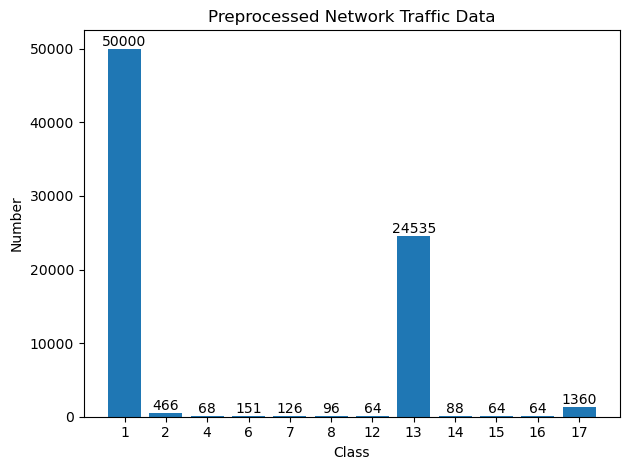

In [17]:
def bar_class_num(technique_data_size):
    class_num = np.arange(len(technique_data_size))
    # data_nums = plt.bar(class_num, technique_data_size, 0.2)
    data_nums = plt.bar(class_num, technique_data_size)
    for item in data_nums:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
        )
    labels.pop(0)
    plt.xticks(class_num, labels)
    plt.xlabel("Class")
    plt.ylabel("Number")
    plt.title("Preprocessed Network Traffic Data")
    plt.tight_layout()
    plt.savefig("traffic.png", dpi=400)
    plt.show()

technique_data_size = []
df = pd.read_csv(os.path.join(folder, "select_"+filename_label))
labels = df['Label'].unique()
labels = [int(i) for i in labels]
labels.sort()
with open("labels_table.json", "r") as f:
    label_table = json.load(f)

for i in labels:
    if i != 0:
        class_data_size = len(df[df['Label'] == i])
        technique_data_size.append(class_data_size)

print("\nData number:")
for i in labels:
    print("class{0}: {1}".format(i, len(df[df['Label'] == i])))

bar_class_num(technique_data_size)

3. Feature selection
    * remove duplicated
    * remove similar features

In [16]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

df = pd.read_csv(os.path.join(folder, filename_label))
del_list = ['StartTime', 'LastTime']

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# data cleaning
df.drop_duplicates(keep=False, inplace=True)
df.drop(columns=del_list, inplace=True)

# data cleaning for normal data
df_tmp = df.loc[df['Label'] == 0].copy()
df_tmp.drop_duplicates(keep=False, inplace=True)
df_tmp = df_tmp.sample(n=100000, random_state=47)
df.drop(df[df['Label'] == 0].index, inplace=True)
df = pd.concat([df, df_tmp])

# data cleaning for class 1 data (port scanning)
df_tmp = df.loc[df['Label'] == 1].copy()
df_tmp.drop_duplicates(keep=False, inplace=True)
df_tmp = df_tmp.sample(n=50000, random_state=47)
df.drop(df[df['Label'] == 1].index, inplace=True)
df = pd.concat([df, df_tmp])


# # feature scaling
# y_tmp = df['Label']
# df.drop(columns=['Label'], inplace=True)
# for feature in df.columns.values:
#     # scaler = RobustScaler().fit(df[feature].values.reshape(-1, 1))
#     scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
#     # scaler = Normalizer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = QuantileTransformer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = PowerTransformer().fit(df[feature].values.reshape(-1, 1))
#     df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
# df = pd.concat([df, y_tmp], axis=1)


# feature selection
y_tmp = df['Label']
y = df['Label'].values.astype(int)
df.drop('Label', axis=1, inplace=True)
selector = VarianceThreshold(threshold=0)
selector.fit(df)
print(selector.variances_)
constant_columns = [column for column in df.columns
                    if column not in 
                    df.columns[selector.get_support()]]
df.drop(labels=constant_columns, axis=1, inplace=True)

df_tmp = df
corr_features = set()
corr_matrix = df_tmp.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
df.drop(labels=corr_features, axis=1, inplace=True)

df = pd.concat([df, y_tmp], axis=1)


# copy data
for class_label in df['Label'].unique():
    while len(df[df['Label'] == class_label]) < 50:
        tmp_df = df[df['Label'] == class_label]
        df = pd.concat([df, tmp_df])


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, "select_"+filename_label)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 3646136
origin features: 56
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1.]
remain data number: 177082
remain features: 41
